# Importação das bibliotecas

In [108]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Carregamento dos Dados

- Estavam todos concatenados, apenas separados por ';'.

In [151]:
df = pd.read_csv("dataset.csv", delimiter=";")

- Apresentação de 10 linhas do dataset

In [120]:
df.head(10)

,id,issue_date,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,1,2024-10-14 00:00:00.000,7101.0,True,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
1,2,2024-10-16 00:00:00.000,5839.0,True,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,True,AM,not valid
2,3,2024-10-15 16:40:24.000,974.0,False,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
3,4,2024-10-17 00:00:00.000,9099.0,True,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
4,5,2024-10-07 17:04:16.000,3434.0,False,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid
5,6,2024-10-04 00:00:00.000,6668.0,False,4.03,5540.4000,2.500000,0.0,0.0,0.0,0.0,0.00,True,AM,valid
6,7,2024-10-17 00:00:00.000,8788.0,False,4.06,1292.7600,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
7,8,2024-10-17 00:00:00.000,8788.0,False,4.06,36544.0680,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
8,9,2024-10-17 15:09:16.000,974.0,False,10.02,26.6817,2.010000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
9,10,2024-10-14 00:00:00.000,10881.0,True,4.03,1112.7255,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid


# Análise de Dados

## Informações sobre o tipo de cada feature

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16843 entries, 0 to 16842
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           16843 non-null  int64  
 1   issue_date                   16843 non-null  object 
 2   id_supplier                  16675 non-null  float64
 3   iss_retention                16843 non-null  bool   
 4   lc116                        16843 non-null  float64
 5   calculated_value             16843 non-null  float64
 6   iss_tax_rate                 16675 non-null  float64
 7   inss_tax_rate                16843 non-null  float64
 8   csll_tax_rate                16843 non-null  float64
 9   ir_tax_rate                  16843 non-null  float64
 10  cofins_tax_rate              16843 non-null  float64
 11  pis_tax_rate                 16843 non-null  float64
 12  opting_for_simples_nacional  16843 non-null  bool   
 13  state           

- 16843 linhas
- 15 features
    - 10 features numéricas
    - 5 categóricas

- Conversão da coluna lc116 para String.

In [140]:
df['lc116'] = df['lc116'].astype(str)
df['lc116']

0         4.03
1         4.12
2        10.02
3         4.03
4         4.09
         ...  
16838     1.07
16839    16.01
16840     1.07
16841     4.02
16842    14.01
Name: lc116, Length: 16843, dtype: object

- Remoção da coluna ID 

In [141]:
df = df.drop('id', axis = 1)

- Separação das features numéricas e categóricas.

In [154]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

cat_cols = df.select_dtypes(include=["object", "bool"]).columns

print("Colunas Numéricas:", list(num_cols))
print("Colunas Categóricas:", list(cat_cols))

Colunas Numéricas: ['id', 'id_supplier', 'lc116', 'calculated_value', 'iss_tax_rate', 'inss_tax_rate', 'ir_tax_rate', 'pca_tax_rate']
Colunas Categóricas: ['issue_date', 'iss_retention', 'opting_for_simples_nacional', 'state', 'class_label']


## Descrição geral das features numéricas

In [87]:
df.describe()

,id_supplier,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate
count,16675.000000,1.684300e+04,16675.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000
mean,5858.570675,6.026261e+03,2.789753,0.171719,0.497456,0.658386,1.527887,0.331529
std,3165.422598,2.909761e+04,2.323147,1.405455,0.538369,0.790466,1.611165,0.350895
min,6.000000,1.083000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3336.000000,5.700000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5913.000000,1.710000e+03,2.244185,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8520.500000,4.647954e+03,3.292734,0.000000,1.000000,1.500000,3.000000,0.650000
max,11241.000000,1.133142e+06,100.000000,21.446848,1.993938,2.999645,5.997115,2.930112


## Quantidade de valores ausentes

In [88]:
print(df.isnull().sum())

issue_date                       0
id_supplier                    168
iss_retention                    0
lc116                            0
calculated_value                 0
iss_tax_rate                   168
inss_tax_rate                    0
csll_tax_rate                    0
ir_tax_rate                      0
cofins_tax_rate                  0
pis_tax_rate                     0
opting_for_simples_nacional      0
state                          168
class_label                      0
dtype: int64


## Percentual de valores ausentes

In [89]:
print((df.isnull().sum() / len(df)) * 100)

issue_date                     0.000000
id_supplier                    0.997447
iss_retention                  0.000000
lc116                          0.000000
calculated_value               0.000000
iss_tax_rate                   0.997447
inss_tax_rate                  0.000000
csll_tax_rate                  0.000000
ir_tax_rate                    0.000000
cofins_tax_rate                0.000000
pis_tax_rate                   0.000000
opting_for_simples_nacional    0.000000
state                          0.997447
class_label                    0.000000
dtype: float64


- como nas colunas categóricas, os valores ausentes são cerca de 1% dos dados totais, essas linhas com dados ausentes provavelmente serão removidas.

## Valores únicos para colunas categóricas

In [90]:
print(df[cat_cols].nunique())

issue_date                     9303
iss_retention                     2
lc116                           118
opting_for_simples_nacional       2
state                             5
class_label                       2
dtype: int64


- Não será considerada as datas para análise de dados

In [96]:
cat_cols = cat_cols[1:]

- Valores únicos graficamente para cada coluna

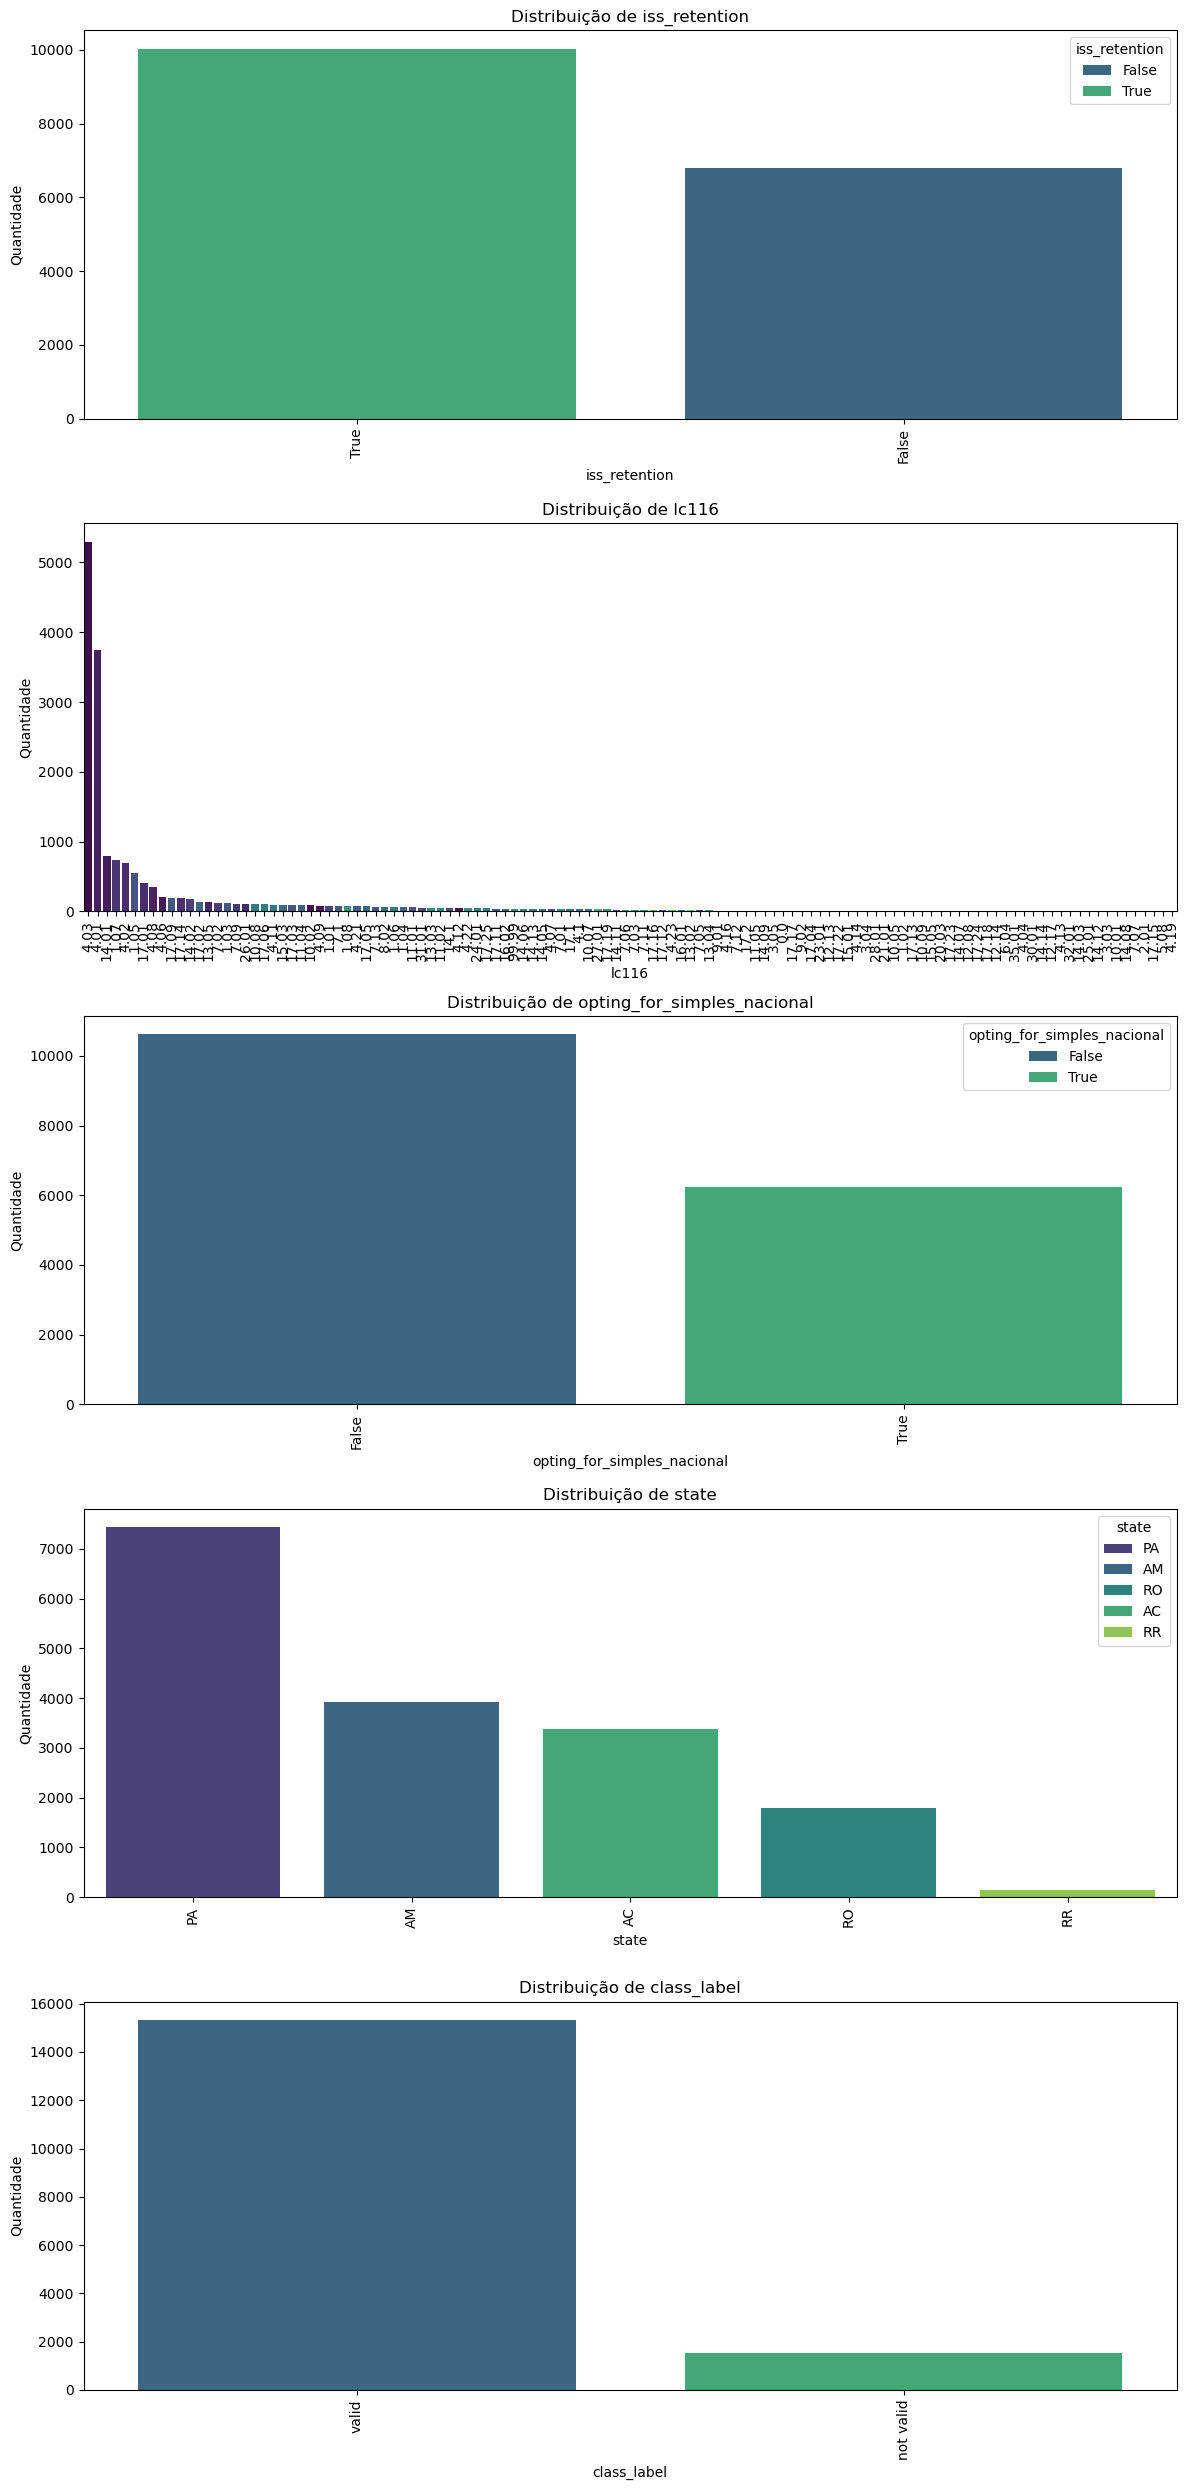

In [98]:
# Definir tamanho da figura
plt.figure(figsize=(12, 5 * len(cat_cols)))

# Criar gráficos para cada coluna categórica
for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)  # Organiza os gráficos verticalmente
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis", hue=col)
    plt.xticks(rotation=90)  # Rotacionar rótulos se necessário
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Quantidade")

# Ajustar layout
plt.tight_layout()
plt.show()

In [54]:
print(df["class_label"].value_counts())

class_label
valid        15320
not valid     1523
Name: count, dtype: int64


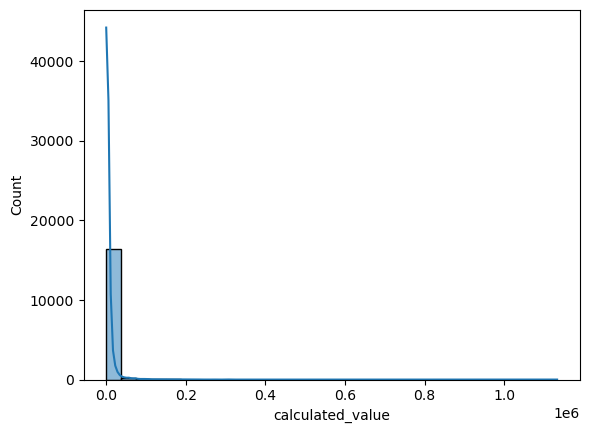

In [57]:
# Histograma de uma variável numérica
sns.histplot(df["calculated_value"], bins=30, kde=True)
plt.show()

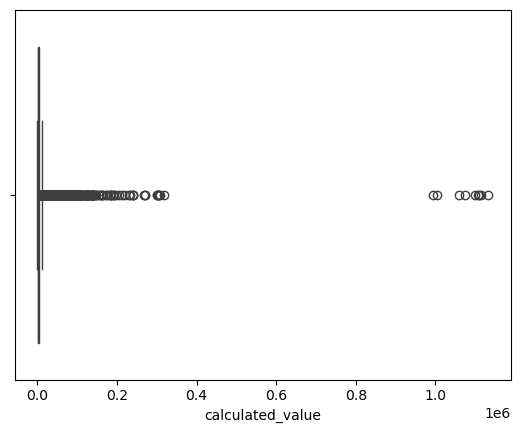

In [58]:
# Boxplot para visualizar outliers
sns.boxplot(x=df["calculated_value"])
plt.show()

## Matriz de correlação

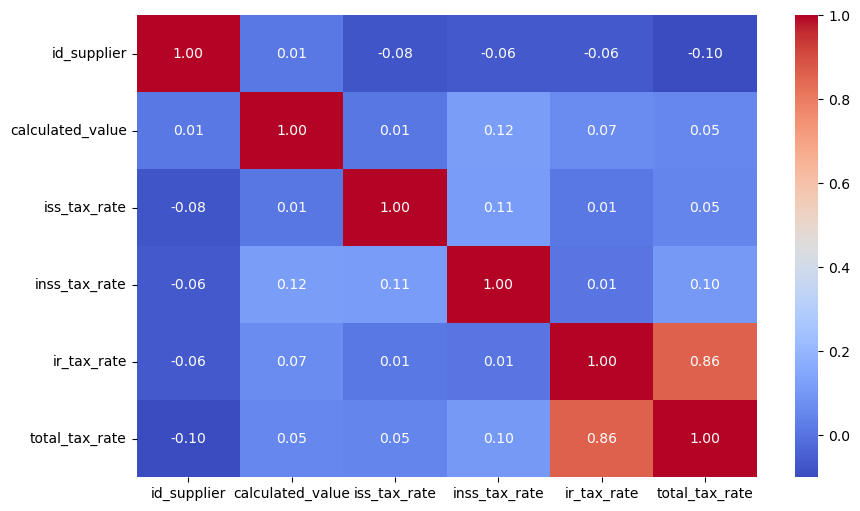

In [149]:
corr_matrix = df[num_cols].corr()

# Mapa de calor da correlação
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

### Solução 1 - Multicolinearidade alta

In [125]:
df = df.drop('cofins_tax_rate', axis = 1) 

In [131]:
df.drop(columns=["pis_tax_rate"], inplace=True)

Feature       VIF
0       id_supplier  1.980720
1  calculated_value  1.061692
2      iss_tax_rate  1.922825
3     inss_tax_rate  1.079189
4     csll_tax_rate  6.290848
5       ir_tax_rate  5.867378

### Solução 2 - Multicolinearidade alta

In [143]:
df["total_tax_rate"] = df["cofins_tax_rate"] + df["pis_tax_rate"]
df.drop(columns=["cofins_tax_rate", "pis_tax_rate"], inplace=True)

In [147]:
df["total_tax_rate"] = df["total_tax_rate"] + df["csll_tax_rate"]
df.drop(columns=["csll_tax_rate"], inplace=True)

            Feature       VIF
0       id_supplier  1.989667
1  calculated_value  1.060664
2      iss_tax_rate  1.925771
3     inss_tax_rate  1.081678
4       ir_tax_rate  6.697275
5    total_tax_rate  7.325354

### Solução 3 - Multicolinearidade alta

In [152]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Padronizar os dados antes do PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["csll_tax_rate", "cofins_tax_rate", "pis_tax_rate"]])

# Aplicar PCA para reduzir para 1 componente
pca = PCA(n_components=1)
df["pca_tax_rate"] = pca.fit_transform(df_scaled)

# Remover as colunas originais
df.drop(columns=["csll_tax_rate", "cofins_tax_rate", "pis_tax_rate"], inplace=True)

### Cálculo do VIF

In [155]:
df_num = df[num_cols].dropna()  # Remover valores nulos para o cálculo

# Criar DataFrame com os valores de VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# Mostrar resultados
print(vif_data)

            Feature       VIF
0                id  3.179337
1       id_supplier  3.201538
2             lc116  1.770059
3  calculated_value  1.062506
4      iss_tax_rate  2.176941
5     inss_tax_rate  1.086588
6       ir_tax_rate  5.222234
7      pca_tax_rate  3.482490


## Gráficos

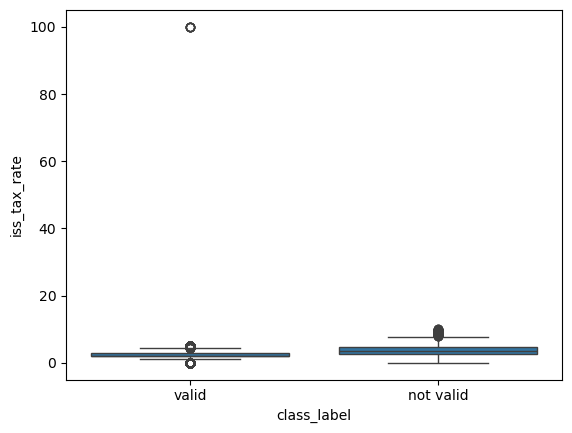

In [101]:
# Comparação entre taxas de imposto para notas válidas e inválidas
sns.boxplot(x=df["class_label"], y=df["iss_tax_rate"])
plt.show()

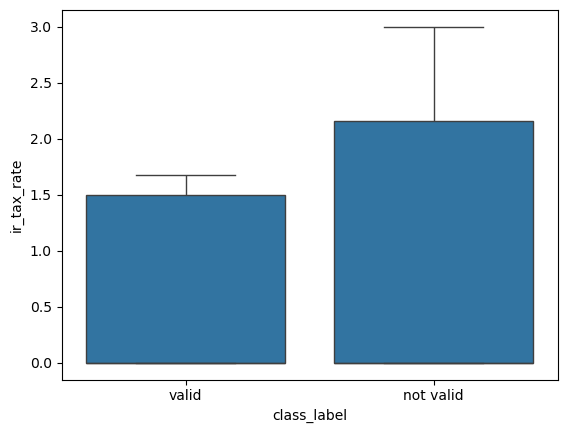

In [102]:
sns.boxplot(x=df["class_label"], y=df["ir_tax_rate"])
plt.show()

# Pré-processamento de Dados

## Limpeza de Dados

## Divisão do Dataset

In [136]:
X = df.drop('class_label', axis=1)
y = df['class_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)